In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv("C:/Users/Usuario/Desktop/repodataia/VOC/AudioProcessing/final_output.csv",sep='#')
# df = pd.read_feather("transcriptions.feather")

In [4]:
# df[['id','speaker']]=df.Name.str.split('--',expand=True)
# df['text']=df['Texto']
# df=df[['text','id','speaker']]

In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.model_selection import StratifiedKFold
import unidecode

from nltk import word_tokenize
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('spanish')
from nltk.corpus import stopwords
import string


In [6]:
df.columns=['id','llamada','text']

In [7]:
df.head()

,id,llamada,text
0,0,_1_1_550113306 Masiva -- speaker0_medium.txt,"Buenas tardes, mi nombre es Elba. A ver, quer..."
1,1,_1_1_556939799 Masiva -- speaker0_medium.txt,"Sí, sí, buenas tardes. Mira, yo, hace toda la..."
2,2,_1_1_549634703 Select -- speaker1_medium.txt,"Hola, qué tal, buenos días. Para hacerte una ..."
3,3,_1_1_545722999 Select -- speaker1_medium.txt,"Banco Santander Buen día, mi nombre es Natali..."
4,4,_1_1_553471694 Select -- speaker1_medium.txt,"Santa Ander buen día, señor Mario Carlos Bran..."


In [8]:
# df=df[df['Label']=='Cliente']
# df=df[df['Label_class']=='TRANSFERENCIAS']

In [9]:
df["text"].dropna(inplace=True)

In [10]:
with open("stop_words_spanish.txt", "rt") as f:
    a=f.readlines()
a = [w[:-1] for w in a]
aux_stop=['aver','ahi','tarjeta','tarjetas','nombre','marido','osvaldo','hermano','vos','ah','hola','que','tal','santander','verdad','eh',
    'si','queria','hacer','buen','consulta','bueno','bien','dia','dale','ok','ah','eh', 'favor','mira',
    'segundo','segundito','escucha', 'ahora','escucho','dale','perfecto','oh' ,'ayudar','gracias','muchisimas',
'igualmente','entonces','bueno','amigo','digamos','usted','si','ver','dias','hola','escuchas','perdon','no'
'tal','hablando','tardes','noches','buen','eh','bien','acá','dia','pues','ayer','como','luego','va','creo',
'despues','señor','señora','digame','viste','hace','eh','sabes','hijo','noviembre','diciembre','octubre','mes',
'hola','vez','dos','mercadolibre','mismo','elba']
a.extend(aux_stop)
a.extend(['asi','nan','mas',"quiero", "se", "hola", "ya", "dia", "buen", "tardes", "gracias", "problema", "te", "quería", "eh", "vos", "mí", "perfecto","listo","dale","ay", "ah", "claro", "tenes", "tu", "mira", "aca","vas", "vale", "pasa", "ok", "mis","veo","favor", "señor", "pido", "digamos", "digo", "viste", "senora", "senor",'elba'])

In [11]:
import re
def accent_preprocesing(df,col):
    #Genero una columna con el texto tal cual el inicial
    df[col+'_ini']=df[col].copy()
    #Elimino los acentos
    dic_replace_acento={'ñ':'zqzq','á':'a','é':'e','í':'i','ó':'o','ú':'u','Á':'A','É':'E','Í':'I','Ó':'O','Ú':'U'}
    for i,j in dic_replace_acento.items():
        df[col] = df[col].apply(lambda x: re.sub(i,j,str(x)))

accent_preprocesing(df,'text')

def Apply_dic_business(df,col):
    global diccionario_negocio
    diccionario_negocio={'fondo comun':'fondocomun','stop debit':'stopdebit','mxn':'pesos','credito visa':'tarjetacredito',
    'tarjeta credito':'tarjetacredito','tarjeta debito':'tarjetadebito','american express':'tarjetacredito',
    'debito automatico':'debitoautomatico','debitos automaticos':'debitosautomaticos','home banking':'homebanking',
    'plazo fijo':'plazofijo','mercado pago':'mercadopago'}
    for i,j in diccionario_negocio.items():
        df[col] = df[col].apply(lambda x: re.sub(i,j,x))
    pass

Apply_dic_business(df,'text')
    

In [24]:
df["text"].astype(str)
texts = df["text"].values
translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))

texts = [str(s).translate(translator) for s in texts] #Ajusta un poco las palabras
texts = [word_tokenize(s) for s in texts] #tokeniza
texts = [[w.lower() for w in s] for s in texts] #a lower
texts = [[unidecode.unidecode(w) for w in s] for s in texts] #Elimina acentos
texts = [['' if t in a else t for t in s] for s in texts] #elimina las palabras que estan en una lista
texts = [" ".join(s) for s in texts]
vec = TfidfVectorizer(min_df = 10, max_df = 1.0, ngram_range=(1,3), stop_words= a) 
X = vec.fit_transform(texts)

In [13]:
# import gensim
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.datasets import make_multilabel_classification

lda = LatentDirichletAllocation(n_components=15,
    random_state=0,)
lda.fit(X)

# get topics for some given samples:
lda.transform(X[-2:])

array([[0.02267269, 0.0226727 , 0.02267269, 0.02267273, 0.02267275,
        0.0226727 , 0.0226727 , 0.02267269, 0.02267278, 0.02267269,
        0.02267275, 0.02267271, 0.0226727 , 0.02267268, 0.68258205],
       [0.01331935, 0.01331936, 0.01331933, 0.01331935, 0.01331937,
        0.01331965, 0.01331956, 0.01331936, 0.01331935, 0.46878498,
        0.01331936, 0.01331934, 0.35806294, 0.01331935, 0.01331935]])

In [14]:
lda = NMF(n_components=5,
    random_state=0,max_iter=1000)
lda.fit(X)

# clf = MultinomialNB()
# y = df.Label_class.tolist()
# clf.fit(vec.transform(df["text"].values),y)

#Puedo cargar un lda o un NB

NMF(max_iter=1000, n_components=5, random_state=0)

In [15]:
# topics = lda.components_
# class_vectors = np.exp(clf.feature_log_prob_)
# sims = np.dot(class_vectors, topics.T)
# best_class = list()
# best_topic = list()
# for _ in range(14):
#     clase, topic = np.unravel_index(sims.argmax(), sims.shape)
#     best_class.append(clf.classes_[clase])
#     best_topic.append(topic+1)
#     sims[clase,:]=0.0
#     sims[:,topic]=0.0

In [16]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(6, 5, figsize=(30, 45), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

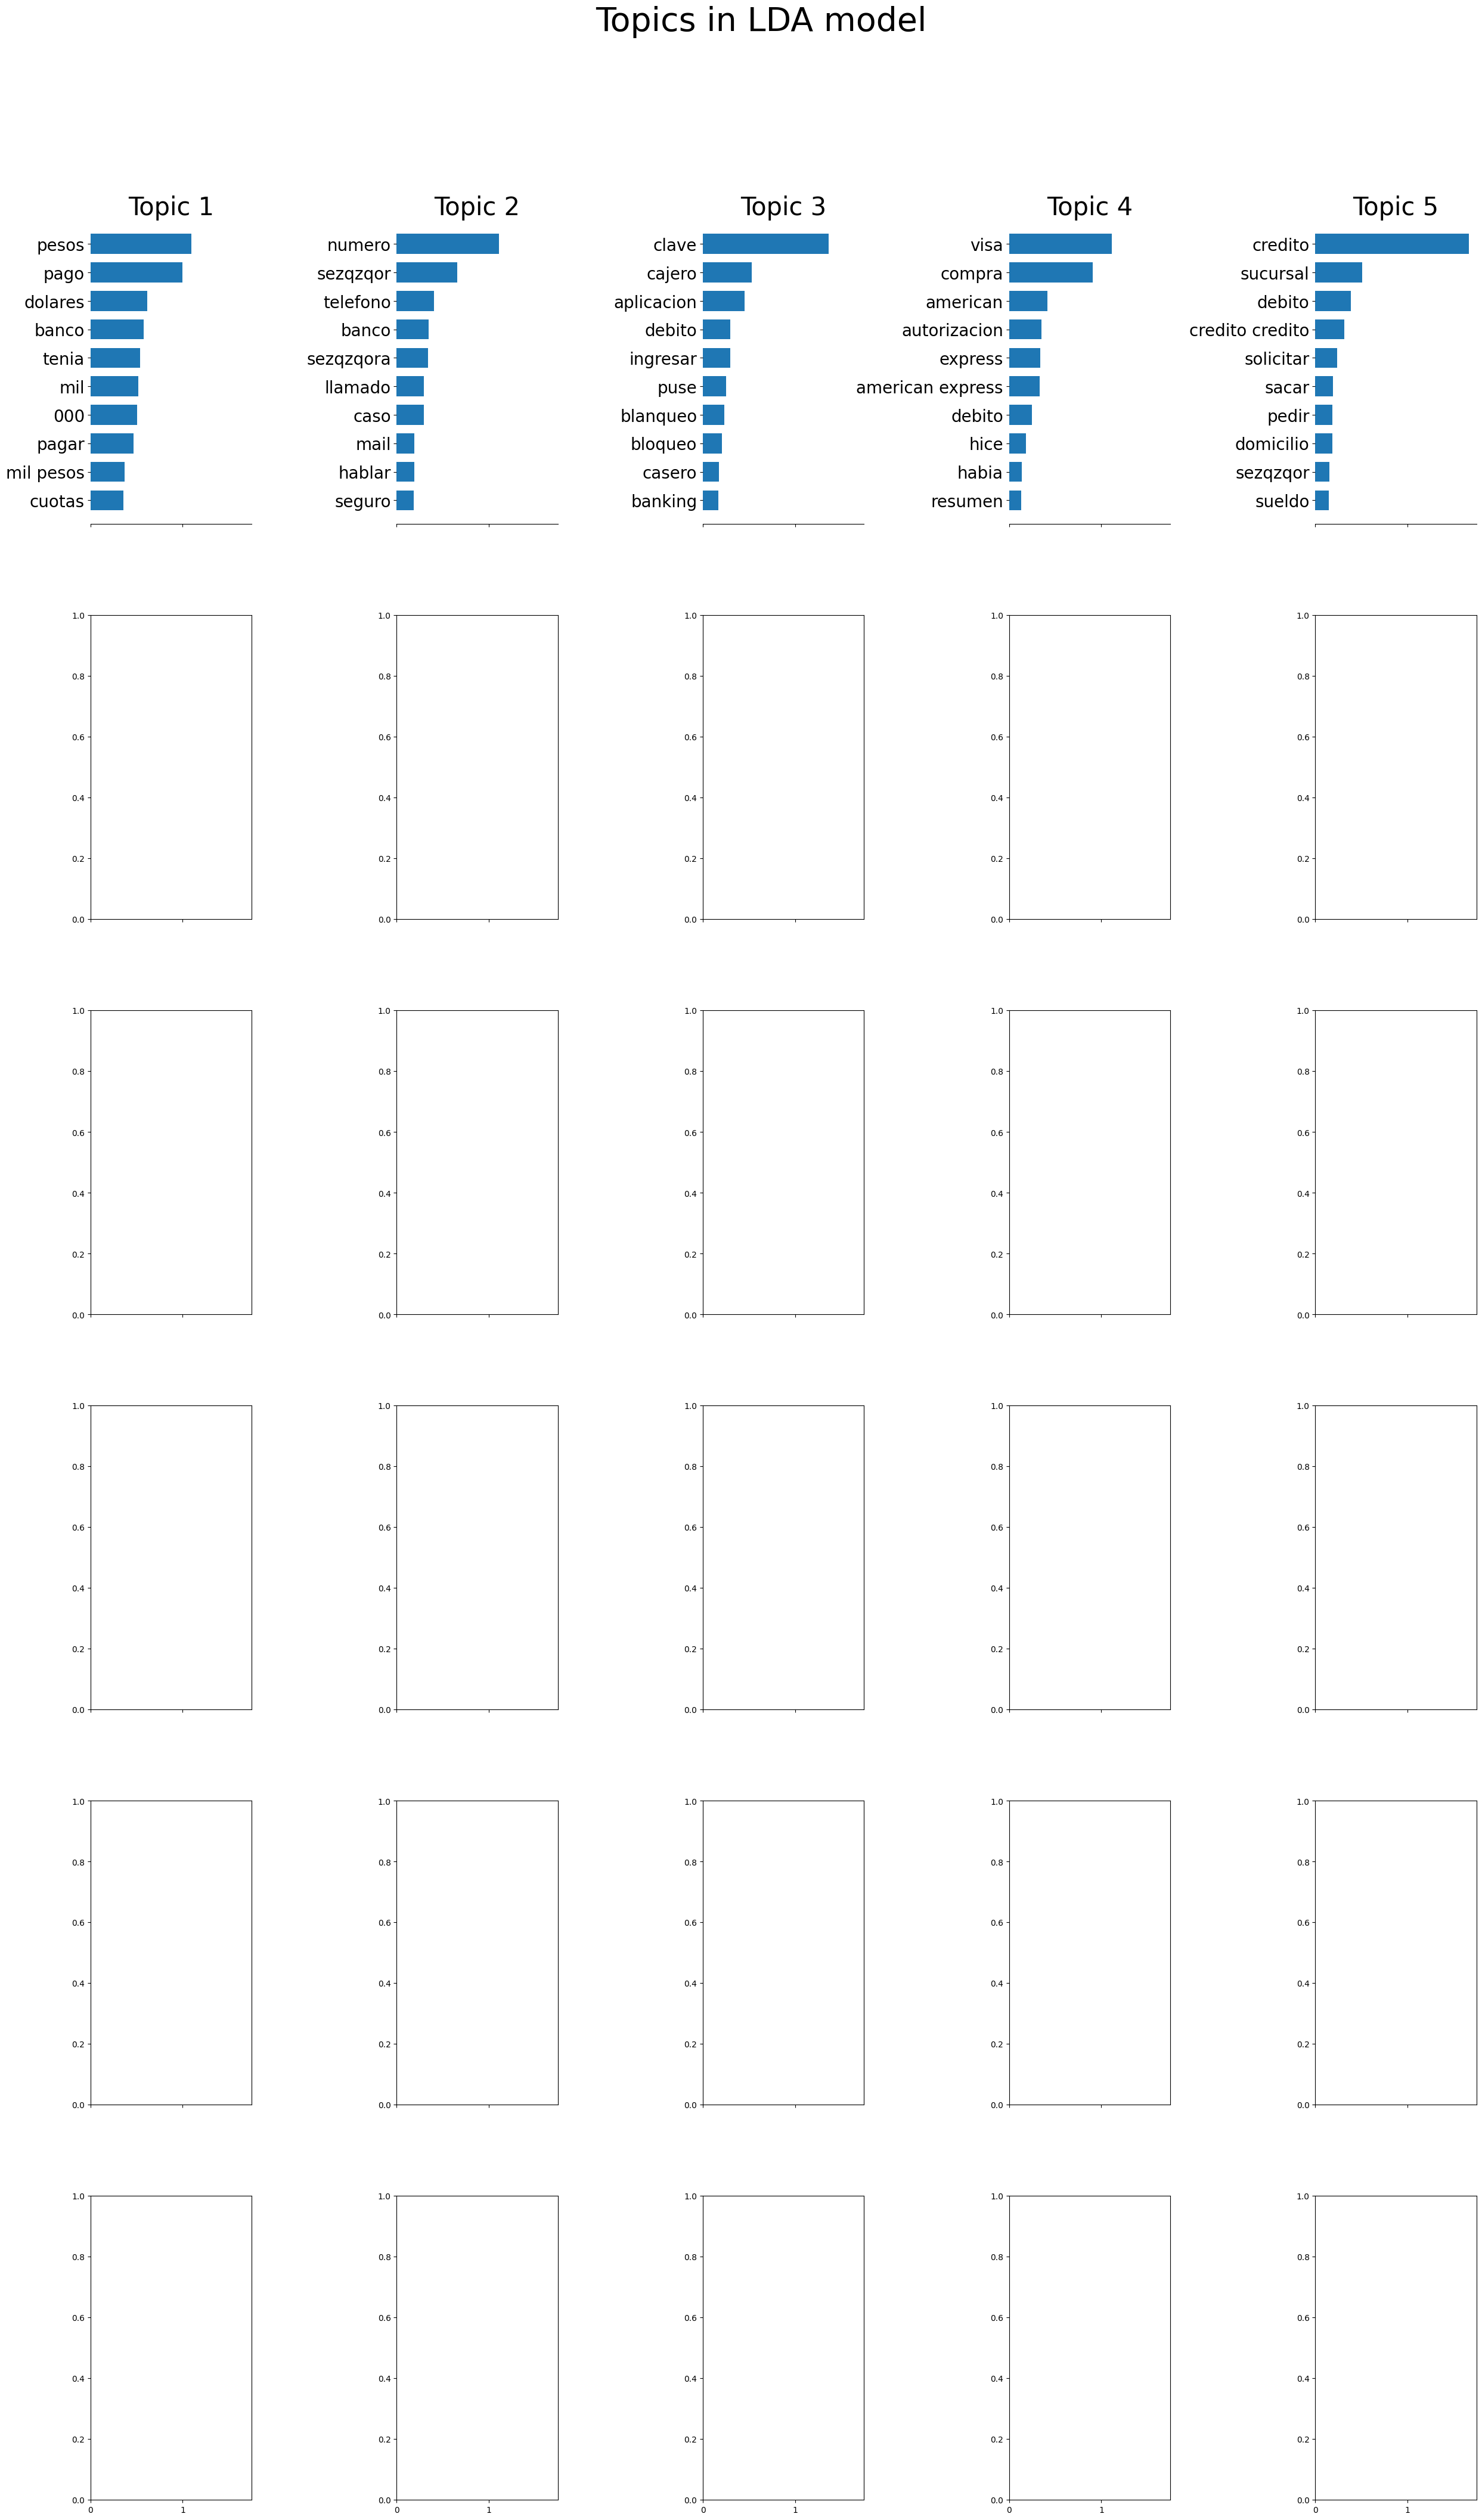

In [17]:
from matplotlib import pyplot as plt
plot_top_words(lda, vec.get_feature_names_out(), 10, "Topics in LDA model")

In [18]:
desc_topicos=['Topico 1','Topico 2','Topico 3','Topico 4','Topico 5','Topico 6',]
# desc_topicos = ["Tarjetas Consumos", "Claves", "Inglés", "Sucursales", "Seguros","6", "Tarjeta Solicitud", "Pagos", "Inversiones","Transferencias", "Encuesta final", "Tarjeta Consumos", "Autorización Compra", "Límite", "Sueldos", "Stop Debit", "Bonificaciones", "Préstamos", "Extracciones", "20", "Turno", "22", "Mercado Pago", "24", "App", "Tarjeta Débito", "Tarjetas", "Problema de comunicación", "29", "Gestiones Especiales"]

In [19]:
colors = ['\033[95m','\033[96m','\033[92m','\033[93m','\033[94m','\033[91m','\033[0m','\033[1m','\033[4m']

def analyze(text, length=100, overlap = 0):
    # length = max([len(text)//8,300])
    sub_text = [text[i:i+length] for i in range(0, len(text), length-overlap)]
    for idx,texto in enumerate(sub_text):
        print(colors[idx], texto, end="")
    print()
    x = vec.transform(sub_text)
    topics_list = lda.transform(x)
    topics_list = (topics_list.T/topics_list.sum(axis=-1)).T
    for idx,topics in enumerate(topics_list):
        for topico, desc in zip(topics, desc_topicos):
            if topico > 0.1:
                print(colors[idx],desc, ":", topico)

In [21]:
analyze(texts[10], 250, overlap = 10)

  ?que         aparecer      empezo  pandemia   vencio    debito     estaria  tema      iba  llegar  banco  iba  llegar   domicilio    todavia   navidades     situacion    !buenisimo   buenisimo ?y               buenisimo ?te repito  domicilio         io          buenisimo  re agradezco    tema     vencida  quise comprar       aceptan       tema  compras  usarla     habia pedido  mayo   vencio   empezo  pedir     tuve  novedades    agradezco   atencion buenisimo        agradezco     chau chau   chau 
 Topico 1 : 0.15954705179212147
 Topico 2 : 0.10762913010034646
 Topico 3 : 0.17965470828561655
 Topico 4 : 0.11460256823111468
 Topico 5 : 0.4385665415908007
 Topico 1 : 0.2319540186517603
 Topico 2 : 0.12723097626988344
 Topico 4 : 0.20570928683270207
 Topico 5 : 0.3368744213591057


C:\Users\Usuario\AppData\Local\Temp\ipykernel_12820\2822962125.py:11: RuntimeWarning: invalid value encountered in divide
  topics_list = (topics_list.T/topics_list.sum(axis=-1)).T
